# Investigation of Strava Personal Fitness Data
## by Daniel Mayer

## Investigation Overview

In this investigation, I aim to understand trends in key running fitness variables (heart rate, pace, distance, and cadence) that influence how my overall fitness has changed over time.

## Dataset Overview

The data consisted up a bulk download from Strava of my 500+ fitness activities logged since 2018, including attributes such as sport, date, time, distance, speed, cadence and heart rate.

### ***Click the down arrow to see visualizations on each page***

In [1]:
# import all packages and set plots to be embedded inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import datetime
import regex as re
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('activities.csv')
activities = df.copy()
activities = activities[['Activity ID','Activity Date','Activity Name','Activity Type','Activity Description','Relative Effort',
             'Elapsed Time','Moving Time','Distance.1','Elevation Gain',
             'Average Cadence','Max Heart Rate','Average Heart Rate','Average Watts','Calories','Grade Adjusted Distance',
             'Weather Condition','Weather Temperature','Humidity','Wind Speed']]

activities.rename(columns={'Activity ID':'activity_id','Activity Date':'timestamp','Activity Name':'name','Activity Type':'sport',
                       'Activity Description':'description','Relative Effort':'relative_effort','Elapsed Time':'elapsed_time',
                       'Moving Time':'moving_time','Distance.1':'distance',
                       'Elevation Gain':'elevation_gain','Average Cadence':'cadence','Max Heart Rate':'max_HR',
                       'Average Heart Rate':'avg_HR','Average Watts':'avg_power','Calories':'calories',
                       'Grade Adjusted Distance':'grade_adj_dist','Weather Condition':'weather',
                       'Weather Temperature':'temperature','Humidity':'humidity','Wind Speed':'wind_speed'},inplace=True)

In [3]:
activities['activity_id'] = activities['activity_id'].astype('object')
activities['timestamp'] = pd.to_datetime(activities['timestamp'])
activities['sport'] = activities['sport'].astype('category')
activities['weather'] = activities['weather'].astype('category')
activities['elapsed_time'] = activities['elapsed_time'].astype('int64')
activities['moving_time'] = activities['moving_time'].astype('int64')

In [4]:
activities['avg_HR'] = activities['avg_HR'].round(decimals=0)
activities['cadence'] = activities['cadence'].round(decimals=0)
activities['avg_power'] = activities['avg_power'].round(decimals=0)
activities['calories'] = activities['calories'].round(decimals=0)

#round distance and elevation to two decimals (that is more than enough accuracy for this investigation)
activities['distance'] = activities['distance'].round(2)
activities['elevation_gain'] = activities['elevation_gain'].round(2)

In [5]:
from pytz import timezone

#Set the timezone on all activities to GMT (assumed Strava default)
activities['timestamp'] = activities['timestamp'].dt.tz_localize('GMT')

#Convert the time zone on all activities to Eastern time
activities['timestamp'] = activities['timestamp'].dt.tz_convert('Canada/Eastern')

In [6]:
fields = ['avg_HR','cadence','distance','avg_power']

for field in fields:
    activities[field].replace(0,np.nan,inplace=True)
    
activities['speed_kph'] = round((activities['distance'] / activities['moving_time']) * 3.6, 2)

In [7]:
running = activities[activities['sport'] == 'Run']
cycling = activities[activities['sport'].isin(['Ride','Virtual Ride'])]
swimming = activities[activities['sport'] == 'Swim']
other = activities[~activities['sport'].isin(['Run','Ride','Virtual Ride','Swim'])]

In [8]:
running['pace_km'] = round((running['moving_time'] / (running['distance'] / 1000)))
running['cadence'] = running['cadence'] * 2

def format_pace(seconds):
    return re.sub('^0:0','',str(datetime.timedelta(seconds=seconds)))

## Number of Activities by Sport

I went from being a balanced triathlete in 2019 to more of a runner during the pandemic in 2020. Good news is my the total number of annual activities is trending upward, nearly eclipsing 250 in 2020.

In [9]:
year = activities.groupby(activities["timestamp"].dt.year).timestamp.count()
run_year = running.groupby(activities["timestamp"].dt.year).timestamp.count()
bike_year = cycling.groupby(activities["timestamp"].dt.year).timestamp.count()
swim_year = swimming.groupby(activities["timestamp"].dt.year).timestamp.count()

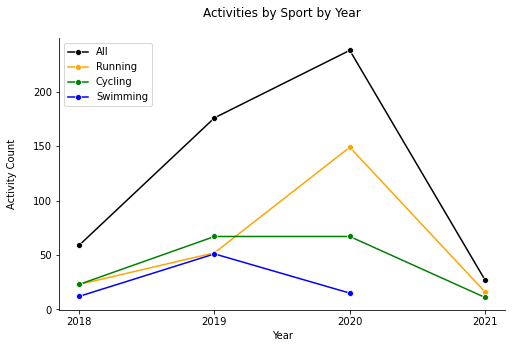

In [10]:
xticks = np.arange(2018,2021+1,1)

ax = plt.figure(figsize=(8,5))
ax = sns.lineplot(x=year.index,y=year,color='black',marker='o')
ax = sns.lineplot(x=run_year.index,y=run_year,color='orange',marker='o')
ax = sns.lineplot(x=bike_year.index,y=bike_year,color='g',marker='o')
ax = sns.lineplot(x=swim_year.index,y=swim_year,color='b',marker='o')
plt.xticks(xticks)
plt.xlabel('Year')
plt.ylabel('Activity Count\n')
plt.title('Activities by Sport by Year\n')
plt.legend(['All','Running','Cycling','Swimming'],loc="upper left")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Distribution of Running Cadence

Up until summer 2020, I was primarily a low cadence running, with my typical average steps per minute hovering around 160. However, I consciously changed that strategy in 2020, which is why the overall distribution has built up a larger right tail in the mid 170s.

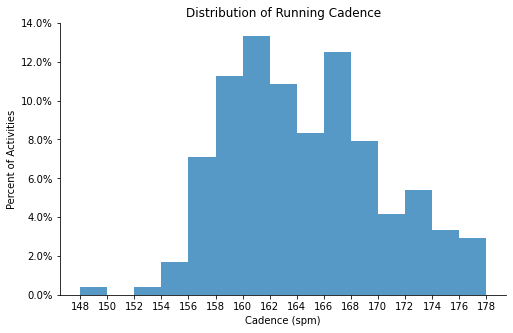

In [11]:
binsize = 2
bins = np.arange(running['cadence'].min(), running['cadence'].max()+binsize, binsize)
weights = np.ones(len(running['cadence'])) / len(running['cadence'])

fig = plt.figure(figsize=[8, 5])
ax = sns.histplot(x = running['cadence'], bins=bins, linewidth=0, weights=weights)
#plt.xlim(bins[0], bins[-1])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Cadence (spm)')
plt.ylabel('Percent of Activities')
plt.title('Distribution of Running Cadence')
plt.xticks(bins)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Heart Rate vs Pace Across Cadence Classes
I classified cadence values as either Low(< 160spm), Medium (160-168spm), or High (> 168spm) and labelled each activity on a plot of heart rate versus pace. A higher cadence is directly related to an increased average heart rate and faster pace. This is particularly true with the "High" cadence activities. There are no purple data points slower than about 6:00/km and with an average heart rate lower than 130. logically it makes sense, as the body needs to work harder but in turn will go faster if the legs are turning over more quickly. 

Right now there is also not a lot of different in pace between my medium and high cadence runs. This may change after a few more months of high-cadence training.

In [12]:
#Cadence classes

print(running.describe().cadence) #cadence distribution
bin_edges = [148,160,168,178] #define the bin edges to cut the data into groups
bin_names = ['low','medium','high'] #name each class
running['cadence_class'] = pd.cut(running['cadence'],bin_edges,labels=bin_names) #apply tiering in a new column in df

count    215.000000
mean     163.627907
std        5.687432
min      148.000000
25%      160.000000
50%      162.000000
75%      168.000000
max      178.000000
Name: cadence, dtype: float64


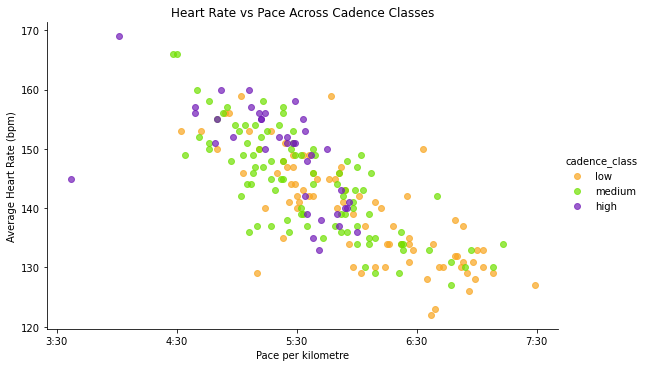

In [13]:
color = {'color': ['#f9a620','#70e000','#721cb8']}
pace_xticks = np.arange(running['pace_km'].min()-7, running['pace_km'].max()+60, 60)
pace_labels = [format_pace(v) for v in pace_xticks]

g = sns.FacetGrid(data=running, hue='cadence_class', hue_kws=color, height=5, aspect=1.6)
g.map(plt.scatter,'pace_km','avg_HR',alpha=0.7)
g.add_legend()
g.set(xticks=pace_xticks)
g.set_xticklabels(pace_labels)
plt.xlabel('Pace per kilometre')
plt.ylabel('Average Heart Rate (bpm)')
plt.title('Heart Rate vs Pace Across Cadence Classes')
plt.show()

## Distribution of Relative Effort

Relative Effort is a metric Strava calculates to determine how difficult an individual activity was compared to a baseline. Given the right skew, I used a logarithmic scale to plot the distribution. There is a peak in relative effort between 30-40, which appears to be a common effort level for my workouts.

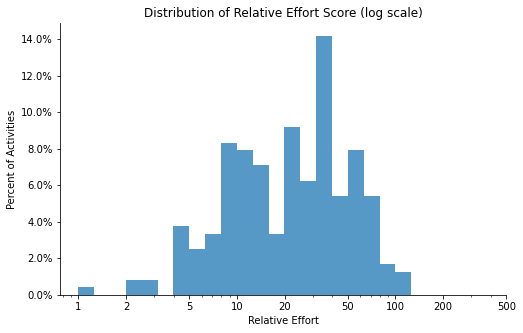

In [14]:
np.log10(running['relative_effort'].describe()) #determine the min and max values on a log scale
bins = 10 ** np.arange(0,2.4,0.1) #set the bins using the min and max log values and arbitrary step size
ticks = [1,2,5,10,20,50,100,200,500]
labels = ['{}'.format(v) for v in ticks]
weights = np.ones(len(running['cadence'])) / len(running['cadence'])

fig = plt.figure(figsize=[8,5])
ax = sns.histplot(x = running['relative_effort'], linewidth=0,bins=bins,weights=weights)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Relative Effort')
plt.ylabel('Percent of Activities')
plt.title('Distribution of Relative Effort Score (log scale)')
plt.xscale('log')
plt.xticks(ticks,labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Heart Rate vs Distance Across Relative Effort Classes
Liek with cadence, I created classes of Relative Effort values to try and uncover trends. I classified relative effort values as either Low(< 20), Medium (20-50), or High (> 50). Heart Rate and Distance were two of the factors that correlated highest with relative effort.

The class distinction is much more clear for Relative Effort than it was with cadence. As distance and heart rate increase, so does relative effort. Heart Rate appears to have an especially large impact, as the high Relative Effort activities are slightly shifted up on the chart.

In [15]:
#Relative Effort classes

bin_edges = [1,20,50,232]
bin_names = ['low','medium','high']
running['RE_class'] = pd.cut(running['relative_effort'],bin_edges,labels=bin_names)

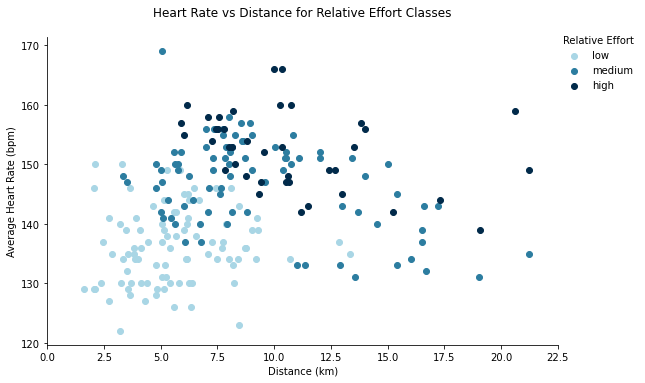

In [16]:
dist_xticks = [0,2500,5000,7500,10000,12500,15000,17500,20000,22500]
dist_labels = [v/1000 for v in dist_xticks]
color = {'color': ['#a9d6e5','#2c7da0','#012a4a']}

g = sns.FacetGrid(data=running, hue='RE_class', hue_kws=color, height=5, aspect=1.6)
g.map(plt.scatter,'distance','avg_HR')
g.add_legend(title= 'Relative Effort',loc='upper right', bbox_to_anchor=(1, 1))
g.set(xticks=dist_xticks)
g.set_xticklabels(dist_labels)
plt.xlabel('Distance (km)')
plt.ylabel('Average Heart Rate (bpm)')
plt.title("Heart Rate vs Distance for Relative Effort Classes\n")
plt.show()

## Running Volume over Time (30 Day Moving Average)

The 30 day average smooths out day to day fluctuations in the data and clearly shows the periods of time when I was running consistently. The blue highlights appear on dates where my running distance in the previous 30 days was greater than 120km (an arbitrary threshold I try and target).

It's not surprising that 2020 was my most consistent running year, given my focus on longer, slower runs and the lack of swim workouts with pools closed due to the pandemic.

In [17]:
def calendar_dates():
    """Generates a list of all dates between a start and end point"""

    first = running['timestamp'].dt.strftime("%d-%m-%Y").iloc[0]
    last = running['timestamp'].dt.strftime("%d-%m-%Y").iloc[-1]

    start = datetime.datetime.strptime(first, "%d-%m-%Y")
    end = datetime.datetime.strptime(last, "%d-%m-%Y")
    date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
    
    return date_generated

In [18]:
all_dates = pd.DataFrame(calendar_dates(), columns=['calendar_date'])
all_dates.calendar_date = all_dates.calendar_date.dt.date

run_dates = running[['timestamp','distance']]
run_dates.timestamp = run_dates.timestamp.dt.date

df2 = all_dates.merge(run_dates, how='left',left_on='calendar_date',right_on='timestamp')
df2.drop(columns='timestamp',inplace=True)
df2['distance'].replace(np.nan,0,inplace=True) #convert NaN to 0
df2['distance'] = df2['distance']/1000 #convert distance to km

df2['30_day_MA'] = df2.iloc[:,1].rolling(window=30).sum()
over_120 = df2[df2['30_day_MA'] > 120]

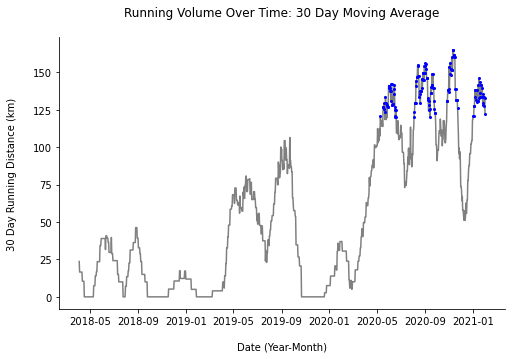

In [19]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df2['calendar_date'],df2['30_day_MA'],c='grey')
ax.plot(over_120['calendar_date'],over_120['30_day_MA'],c='blue',marker='o',markersize=2,ls='')
ax.set_xlabel('\nDate (Year-Month)')
ax.set_ylabel('30 Day Running Distance (km)\n')
ax.set_title('Running Volume Over Time: 30 Day Moving Average\n')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Fitness Level over Time

For this analysis, I created a simplistic "Fitness Score" ratio as a normalized way to compare how well I performed in each activity. The score is a ratio of Speed / Average Heart Rate multiplied by 100. A higher value indicates greater fitness. I am assuming that a lower heart rate and/or a higher speed are associated with higher fitness. I recognize that this is not nearly as robust as something like VO2 Max, but it does factor in distance and time, as they are used to calculate speed.

On a first look at this simplistic metric over time, you might conclude that I am not getting much fitter over time. However, as this is my own personal data, I know there are other factors that may not be reflected here. For instance, I recently started training at a higher cadence, which boosts up heart rate without the immediate corresponding payoff in speed. I also tend to battle a lot of injuries in peak season and slack off a bit in the fall/winter. Finally, my wrist heart rate sensor is sometimes inaccurate which can lead to some inaccurate results and artificial inflation or deflation of certain months.

In [20]:
running['fitness_score'] = (running['speed_kph'] / running['avg_HR']) * 100

fitness_by_month = running.groupby(running['timestamp'].dt.to_period("M")).fitness_score.mean()
fitness_by_month = fitness_by_month.reset_index()
fitness_by_month = fitness_by_month[fitness_by_month['fitness_score'].notnull()]
fitness_by_month['timestamp'] = fitness_by_month['timestamp'].astype(str)

high_fitness = fitness_by_month[fitness_by_month.fitness_score > 8]

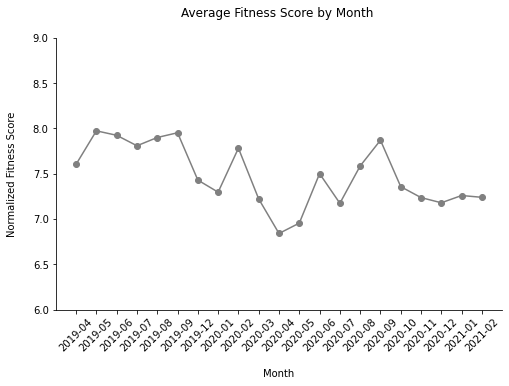

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(fitness_by_month['timestamp'],fitness_by_month['fitness_score'],c='grey',marker='o')
ax.plot(high_fitness['timestamp'],high_fitness['fitness_score'],c='blue',marker='o',markersize=5,ls='')
plt.xticks(rotation=45)
ax.set_xlabel('\nMonth')
ax.set_ylabel('Normalized Fitness Score\n')
ax.set_title('Average Fitness Score by Month \n')
ax.set_ylim(bottom=6,top=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!

In [22]:
!jupyter nbconvert strava_fitness_slide_deck.ipynb --to slides --post serve  --no-input --no-prompt 

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook strava_fitness_slide_deck.ipynb to slides
[NbConvertApp] Writing 771434 bytes to strava_fitness_slide_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\Users\danie\anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\danie\AppData\Roaming\Python\Python37\site-packages\jupyter_core\application.py", line 270, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\danie\AppData\Roaming\Python\Python37\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\danie\AppData\Roaming\Python\Python37\site-packages\nbconvert\nbconvertapp.py", line 350, in start
    self.convert_notebooks()
 